# 2D QLIPP forward simulation
This simulation is based on the QLIPP paper ([here](https://elifesciences.org/articles/55502)): <br>
``` S.-M. Guo, L.-H. Yeh, J. Folkesson, I. E. Ivanov, A. P. Krishnan, M. G. Keefe, E. Hashemi, D. Shin, B. B. Chhun, N. H. Cho, M. D. Leonetti, M. H. Han, T. J. Nowakowski, S. B. Mehta , "Revealing architectural order with quantitative label-free imaging and deep learning," eLife 9:e55502 (2020).```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Key parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
mag         = 40                  # magnification
ps          = 6.5/mag             # effective pixel size
lambda_illu = 0.532               # wavelength
n_media     = 1                   # refractive index in the media
NA_obj      = 0.55                # objective NA
NA_illu     = 0.4                 # illumination NA (condenser)
NA_illu_in  = 0.4                 # illumination NA (phase contrast inner ring)
z_defocus   = (np.r_[:5]-2)*1.757 # a set of defocus plane
chi         = 0.03*2*np.pi           # swing of Polscope analyzer


## Sample : star with uniform phase, uniform retardance, and radial orientation

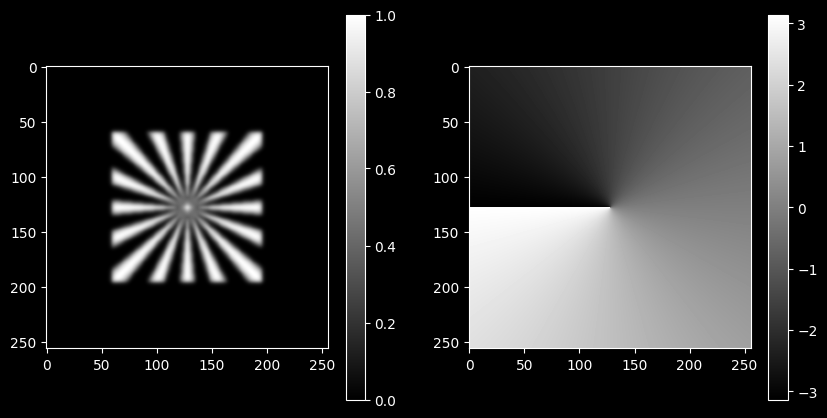

In [3]:
# generate Siemens star pattern

star, theta, _ = wo.genStarTarget(N,M)

wo.plot_multicolumn(np.array([star, theta]), num_col=2, size=5)

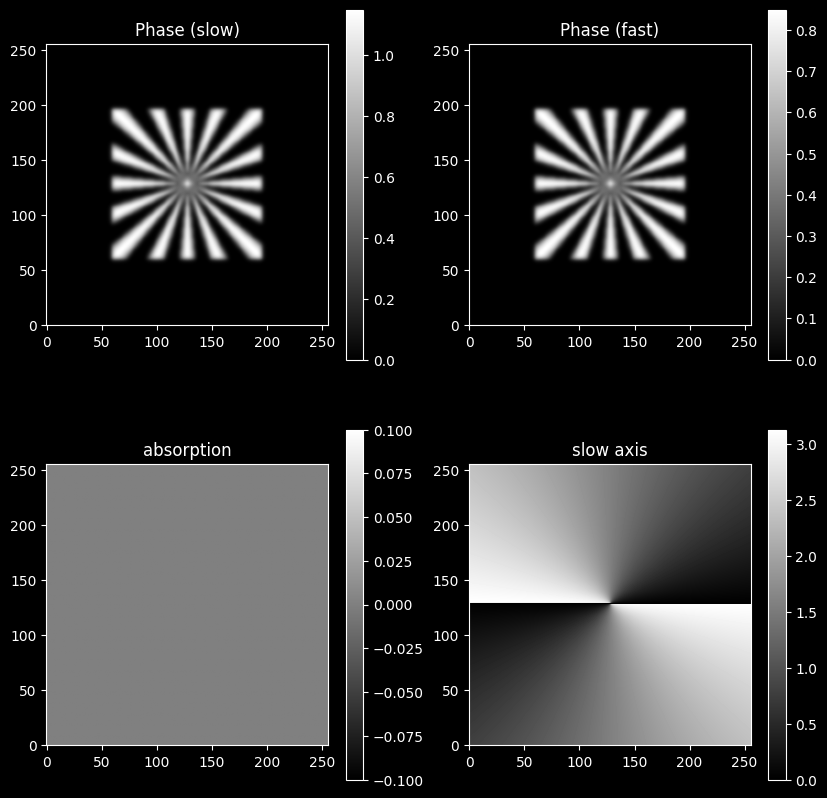

In [4]:
# Assign uniform phase, uniform retardance, and radial slow axes to the star pattern

phase_value = 1 # average phase in radians (optical path length)

phi_s = star*(phase_value + 0.15) # slower OPL across target
phi_f = star*(phase_value - 0.15) # faster OPL across target

mu_s = np.zeros((N,M)) # absorption
mu_f = mu_s.copy()

t_eigen = np.zeros((2, N, M), complex) # complex specimen transmission

t_eigen[0] = np.exp(-mu_s + 1j*phi_s) 
t_eigen[1] = np.exp(-mu_f + 1j*phi_f) 

sa = theta%np.pi #slow axes.

wo.plot_multicolumn(np.array([phi_s, phi_f, mu_s, sa]), \
                     num_col=2, size=5, set_title=True, \
                     titles=['Phase (slow)', 'Phase (fast)', 'absorption', 'slow axis'], origin='lower')



## Forward model of QLIPP <br> (polarization-diverse and depth-diverse acquisition)

#### Source pupil

In [5]:
# Subsample source pattern for speed

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Source_cont = wo.gen_Pupil(fxx, fyy, NA_illu, lambda_illu)


Source_discrete = wo.Source_subsample(Source_cont, lambda_illu*fxx, lambda_illu*fyy, subsampled_NA = 0.1)

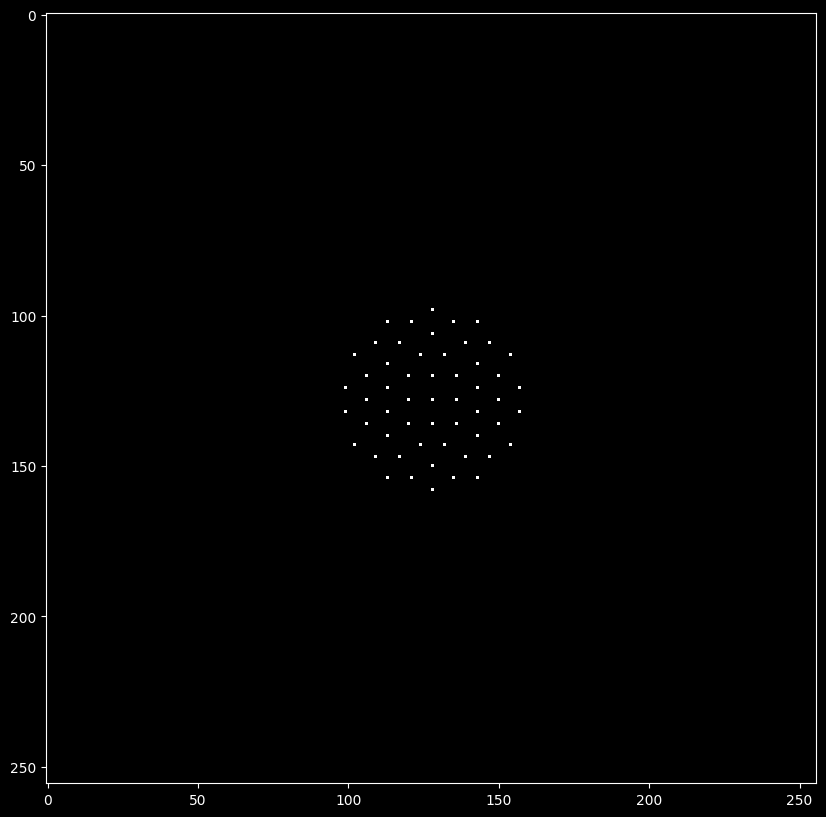

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(Source_discrete),cmap='gray')


#### Initialize microscope simulator with above source pattern and uniform imaging pupil

In [7]:
# Microscope object generation

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, n_media=n_media,\
                                              illu_mode='Arbitrary', Source=Source_discrete)



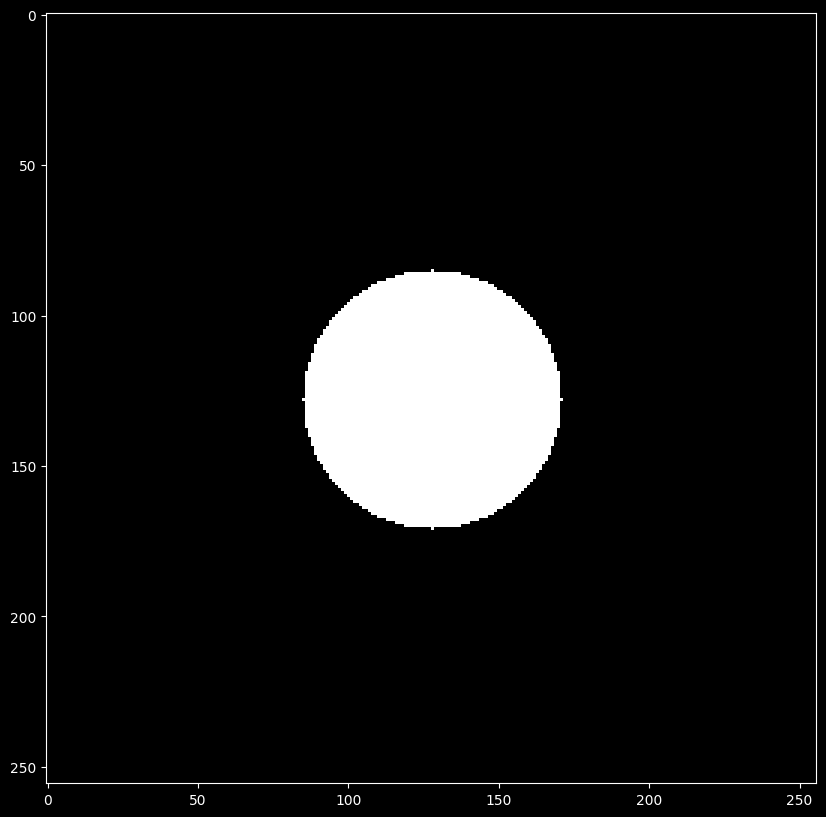

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(fftshift(simulator.Pupil_obj)),cmap='gray')

#### 2D phase transfer function of the microscope at different z

In [10]:
Hz_det = simulator.Hz_det
wo.image_stack_viewer(np.real(np.transpose(fftshift(Hz_det,axes=(0,1)),(2,0,1))))


interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

## Compute image volumes and Stokes volumes

In [11]:
I_meas, Stokes_out = simulator.simulate_waveorder_measurements(t_eigen, sa, multiprocess=False)

Number of sources considered (55 / 55) in pattern (1 / 1), elapsed time: 2.77


In [12]:
wo.parallel_4D_viewer(np.transpose(Stokes_out,(3,0,1,2)), num_col=2, size=5, origin='lower', \
                      set_title=True, titles=[r'$S_0$',r'$S_1$',r'$S_2$',r'$S_3$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [ ]:
# Add noise to the measurement

photon_count = 14000
ext_ratio    = 10000
const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio

I_meas_noise = (np.random.poisson(I_meas/np.max(I_meas) * photon_count + const_bg)).astype('float64')


In [ ]:
wo.parallel_4D_viewer(np.transpose(I_meas_noise,(3,0,1,2)), num_col=3, size=5, origin='lower', \
                      set_title=True, titles=[r'$I_{ext}$',r'$I_{0}$',r'$I_{45}$',r'$I_{90}$', r'$I_{135}$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

#### Save simulation 

In [ ]:

output_file = '2D_QLIPP_simulation'

np.savez(output_file, I_meas=I_meas_noise, Stokes_out=Stokes_out, lambda_illu=lambda_illu, \
                      n_media=n_media, NA_obj=NA_obj, NA_illu=NA_illu, ps=ps, Source_cont=Source_cont, \
                      z_defocus=z_defocus, chi=chi)



In [ ]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()